# CS4035 - Cyber Data Analytics
## Lab 4

### Submit on brightspace (zip file with the name Group_xx.zip)
This jupyter file completed with code, plots, figures and report for each question. Write the code or explanation below each sub question. For the explanations, include what you would normally include in the report for this lab assignment, for example data pre-processing, hypothesis tested, approach, results, etc.

(if you used hard-to-get libraries) The libraries needed to run this file. 

Your peers should be able to use the readme section for instructions and be able to run this file. 

## Group Number : 42

## Student 1 
### Name : Otte Van Dam
### ID : 5096790

## Student 2
### Name : Suhaib Basir
### ID : 5059151

## README

Provide instructions - libraries used, location of the data file, etc. Keep it short. Remember your peers will not debug your code and should be able to reproduce the exact output you provide.

## 1. Preparation (0 points)
### Load imports

In [1]:
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

from tqdm import tqdm

### 1a. Load the dataset and split it into a train and test set

In [2]:
X = np.load('X.npy')
y = np.load('y.npy')

# Split the data into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
model = SGDClassifier(loss='log_loss')

# Fit the model to the training set
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy before attack:", accuracy)

Accuracy before attack: 0.9047697368421053


## 2. Attacking linear models (5 Points)

### 2a. Implementing useless import attacks


In [4]:
def evade(sample, coef):
    for i, c in enumerate(coef):
        if c < 0:
            sample[i] = 1
    return sample

def create_attack(X, y, coef):
    X_attack = []
    for i in range(len(X)):
        sample = X[i]
        if y[i] == 1:
            X_attack.append(evade(sample, coef[0]))
        else:
            X_attack.append(sample)
    return X_attack

In [5]:
X_test_attack = create_attack(X_test, y_test, model.coef_)
# Predict on the test set
y_pred_attack = model.predict(X_test_attack)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred_attack)
print("Accuracy after attack:", accuracy)

Accuracy after attack: 0.42483552631578947


### 2b. Analysis and answers to the questions
The accuracy drops from 92% to 50%. This shows that the model is not robust at all. At this point a random classifier is just as good.

## 3. Improving robustness by hardening (5 Points)

### 3a. Implementing hardening

In [6]:
def hardening(batch_size):
    model_hardening = SGDClassifier(loss='log_loss')

    # batch_size = 24
    num_batches = len(X_train) // batch_size

    coef_hardened = [[0] * len(X_train[0])]

    for batch in (range(num_batches)):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size

        X_batch = X_train[start_idx:end_idx]
        y_batch = y_train[start_idx:end_idx]

        X_batch_attack = create_attack(X_batch, y_batch, coef_hardened)
        model_hardening.partial_fit(X_batch_attack, y_batch, classes=np.unique(y_train))

        coef_hardened = model_hardening.coef_

    X_test_attack_hardened = create_attack(X_test, y_test, coef_hardened)
    y_pred_hardened = model_hardening.predict(X_test_attack_hardened)
    accuracy_hardened = accuracy_score(y_test, y_pred_hardened)
    return accuracy_hardened

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
batch_sizes = [2, 4, 8, 16, 50, 100, 500, 1000, 2000, 2500, 3000, 3500, 4000, 4500]
accuracy_list_hardening = []
for batch_size in tqdm(batch_sizes):
    accuracy_list_hardening.append(hardening(batch_size))

100%|██████████| 12/12 [10:50<00:00, 54.17s/it]


### 3b. Analysis and answers to the questions

## 4. Training non-negative linear models (5 Points)

### 4a. Implement non-negative logistic regression using SGD

In [8]:
def non_negative(batch_size):
    model_non_negative = SGDClassifier(loss='log_loss')

    # batch_size = 24
    num_batches = len(X_train) // batch_size

    for batch in (range(num_batches)):
        start_idx = batch * batch_size
        end_idx = (batch + 1) * batch_size

        X_batch = X_train[start_idx:end_idx]
        y_batch = y_train[start_idx:end_idx]

        model_non_negative.partial_fit(X_batch, y_batch, classes=np.unique(y_train))
        coef_non_negative = model_non_negative.coef_

        for i in range(len(coef_non_negative[0])):
            if coef_non_negative[0][i] < 0:
                coef_non_negative[0][i] = 0

        model_non_negative.coef_ = coef_non_negative

    coef_non_negative = model_non_negative.coef_
    X_test_attack_non_negative = create_attack(X_test, y_test, coef_non_negative)
    y_pred_non_negative = model_non_negative.predict(X_test_attack_non_negative)
    # y_pred_non_negative = model_non_negative.predict(X_test)
    accuracy_non_negative = accuracy_score(y_test, y_pred_non_negative)
    return accuracy_non_negative

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
batch_sizes = [2, 4, 8, 16, 50, 100, 500, 1000, 2000, 2500, 3000, 3500, 4000, 4500]
accuracy_list_non_negative = []
for batch_size in tqdm(batch_sizes):
    accuracy_list_non_negative.append(non_negative(batch_size))
print(accuracy_list_non_negative)

100%|██████████| 12/12 [07:05<00:00, 35.46s/it]

[0.8064144736842105, 0.8101973684210526, 0.8179276315789473, 0.8506578947368421, 0.8162828947368421, 0.7220394736842105, 0.4975328947368421, 0.4975328947368421, 0.4975328947368421, 0.4975328947368421, 0.4975328947368421, 0.49358552631578945]


### 4b. Analysis and answers to the questions.

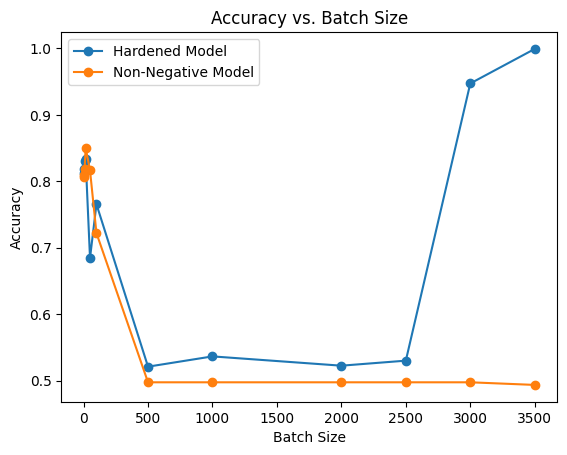

In [10]:
# Plot the accuracies for each batch size
plt.plot(batch_sizes, accuracy_list_hardening, marker='o', label='Hardened Model')
plt.plot(batch_sizes, accuracy_list_non_negative, marker='o', label='Non-Negative Model')

# Add labels and title to the plot
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Batch Size')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [11]:
print(accuracy_list_non_negative)
print(accuracy_list_hardening)

[0.8064144736842105, 0.8101973684210526, 0.8179276315789473, 0.8506578947368421, 0.8162828947368421, 0.7220394736842105, 0.4975328947368421, 0.4975328947368421, 0.4975328947368421, 0.4975328947368421, 0.4975328947368421, 0.49358552631578945]
[0.8129934210526316, 0.8185855263157895, 0.8299342105263158, 0.8337171052631579, 0.6845394736842105, 0.7654605263157894, 0.5210526315789473, 0.5365131578947369, 0.5225328947368421, 0.5300986842105263, 0.9472039473684211, 0.9991776315789473]


## 5. Bonus: robust decision trees for fraud detection (5 Points)

### 5a. Train and analyze a regular decision tree for fraud detection

### 5b. Train and analyze a robust decision tree (GROOT) for fraud detection

### 5c. Evaluate the robustness of the two models